# Applying flat-field corrections

`opticam_new` provides a simple interface for creating and applying image corrections (currently limited to flat-field corrections).

In this notebook, I will demonstrate how to create a master flat, and how this master flat can be incorporated into the reduction process.

## Generating Synthetic Data and Flats

Before applying flat-field corrections, we need some flat-field images. For this tutorial, I will use the `generate_flats()` routine to generate some synethetic flats. I will also generate some synthetic observations using `generate_observations()` with `circular_aperture=True` to impose a circular aperture shadow onto the images:

In [1]:
import opticam_new

opticam_new.generate_observations(
    out_dir='corrections_tutorial/data',
    n_images=10,  # number of images per camera
    circular_aperture=True,  # impose circular aperture shadow on images
    )

opticam_new.generate_flats(
    out_dir='corrections_tutorial/flats',
    n_flats=5,  # number of flats per camera
)

Generating observations: 100%|██████████|[00:02<00:00]
Generating flats: 100%|██████████|[00:00<00:00]


Let's check if our newly created flats are where they should be:

In [2]:
import os

flats = sorted(os.listdir('corrections_tutorial/flats'))
for file in flats[:3]:
    print(file)

g-band_flat_0.fits.gz
g-band_flat_1.fits.gz
g-band_flat_2.fits.gz


We have flats! Note that these files are compressed using gzip to reduce disk space. FITS files do not need to be unzipped to be compatible with `opticam_new` since `astropy.io.fits`, which is used by `opticam_new` to handle FITS files, can seamlessly open `fits.gz` files.

Let's take a look at one of our newly-generated flats:

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
EXTEND  =                    T                                                  
FILTER  = 'g       '                                                            
BINNING = '4x4     '                                                            
GAIN    =                  1.0                                                  
UT      = '2024-01-01 00:00:00'                                                 


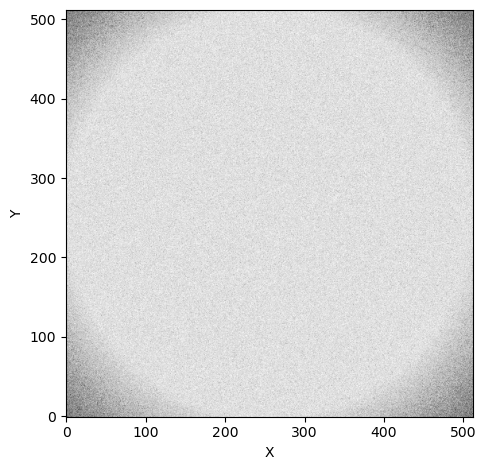

In [3]:
from astropy.io import fits
from astropy.visualization import simple_norm
from matplotlib import pyplot as plt
import numpy as np

# open the first flat field image
file = flats[0]
with fits.open(f'corrections_tutorial/flats/{file}') as hdul:
    print(repr(hdul[0].header))
    flat = np.array(hdul[0].data)

# plot the flat field image
fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(
    flat,
    norm=simple_norm(
        flat,
        stretch="sqrt",
        ),
    origin="lower",
    cmap="Greys_r",
    )

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

These synthetic flats show a circular shadow that you might imagine was caused by the telescope's circular aperture. We also see this shadow in the synthetic observations created by `opticam_new.generate_observations()`:

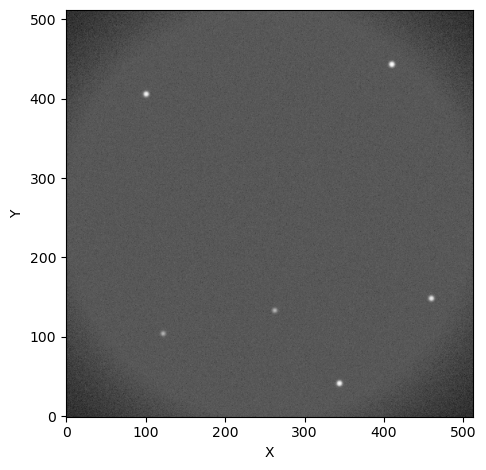

In [4]:
# get the first image
files = sorted(os.listdir('corrections_tutorial/data'))
file = files[0]

# open the image
with fits.open(f"corrections_tutorial/data/{file}") as hdul:
    image = np.array(hdul[0].data)

# plot the image
fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(
    image,
    norm=simple_norm(
        image,
        stretch="sqrt",
        ),
    origin="lower",
    cmap="Greys_r",
    )

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

Just like in the flats, we see a circular shadow at the corners of the image.

## Applying Flat-field Corrections

In `opticam_new`, flat-field corrections are handled by an `opticam_new.FlatFieldCorrector` object. Like `opticam_new.Catalogue`, `opticam_new.FlatFieldCorrector` will split flats by filter if they are all stored in a single directory, or separate directories can be specified for each filter's flats. In this example, all flats are stored in a single directory:

In [5]:
flat_corrector = opticam_new.FlatFieldCorrector(
    out_dir='corrections_tutorial/correctors',  # where the master flat field images will be stored
    flats_dir='corrections_tutorial/flats',  # where the flat field images are stored
    )

[OPTICAM] 5 i-band flat-field images.
[OPTICAM] 5 g-band flat-field images.
[OPTICAM] 5 r-band flat-field images.


When defining a `FlatFieldCorrector` object, an `out_dir` must be specified. This is the directory to which any output files (e.g., the master flats) will be written. 

After creating a `FlatFieldCorrector` instance, you will be able to see how many flats have been detected for each camera. In this case, we can see that each filter has five flat-field images.

### Creating Master Flats (Long Way)

Now that we have a `FlatFieldCorrector` instance, we can either create master flats manually, or pass the `FlatFieldCorrector` object to a `Catalogue` instance, which will automatically create the master flats for us if they do not already exist. In this example, let's create the master flats manually:

In [6]:
flat_corrector.create_master_flats()

Let's take a look at these master flats. We can either read the master flats from their new directory:

In [7]:
flats = sorted(os.listdir('corrections_tutorial/correctors/master_flats'))
for file in flats:
    print(file)

g-band_master_flat.fit.gz
i-band_master_flat.fit.gz
r-band_master_flat.fit.gz


where we can see that each master flat file has also been compressed using gzip, or we can access the master flats directly from `flat_corrector` using the `master_flats` attribute:

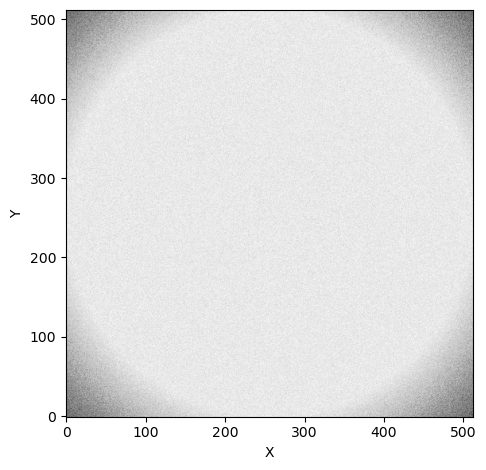

In [8]:
master_flat = flat_corrector.master_flats['g-band']

fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(
    master_flat,
    norm=simple_norm(
        master_flat,
        stretch="sqrt",
        ),
    origin="lower",
    cmap="Greys_r",
    )

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

While not immediately obvious, you should be able to see that the master flat is less noisy than the individual flat shown above:

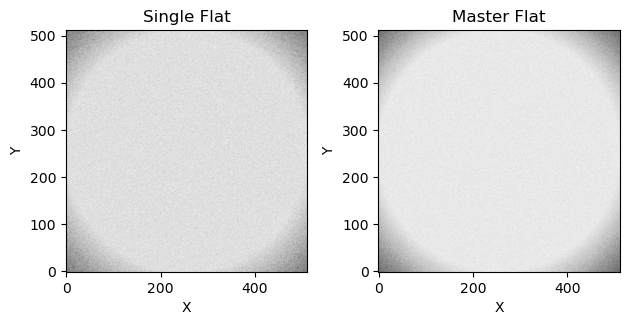

In [9]:
fig, axes = plt.subplots(ncols=2, tight_layout=True)

axes[0].imshow(
    flat,
    norm=simple_norm(
        flat,
        stretch="sqrt",
        ),
    origin="lower",
    cmap="Greys_r",
    )
axes[0].set_title("Single Flat")

axes[1].imshow(
    master_flat,
    norm=simple_norm(
        master_flat,
        stretch="sqrt",
        ),
    origin="lower",
    cmap="Greys_r",
    )
axes[1].set_title("Master Flat")

for ax in axes:
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

plt.show()

### Performing Flat-field Corrections

Let's now use `flat_corrector` to correct an image:

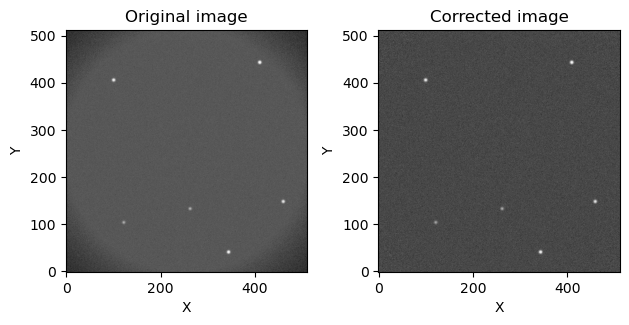

In [10]:
with fits.open(f'corrections_tutorial/data/{files[0]}') as hdul:
    fltr = hdul[0].header['FILTER'] + '-band'
    image = np.array(hdul[0].data)

fig, axes = plt.subplots(
    ncols=2,
    tight_layout=True,
    )

axes[0].imshow(
    image,
    norm=simple_norm(
        image,
        stretch="sqrt",
        ),
    origin="lower",
    cmap="Greys_r",
    )
axes[0].set_title('Original image')

corrected_image = flat_corrector.correct(image, fltr)

axes[1].imshow(
    corrected_image,
    norm=simple_norm(
        corrected_image,
        stretch="sqrt",
        ),
    origin="lower",
    cmap="Greys_r",
    )
axes[1].set_title('Corrected image')

for ax in axes:
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

plt.show()

As we can see, the aperture shadow has been removed!

We can automate the process of applying master flats by passing an `opticam_new.FlatFieldCorrector` instance to `opticam_new.Catalogue`:

[OPTICAM] corrections_tutorial/reduced not found, attempting to create ...
[OPTICAM] corrections_tutorial/reduced created.


[OPTICAM] Scanning data directory: 100%|██████████|[00:00<00:00]


[OPTICAM] Binning: 4x4
[OPTICAM] Filters: g-band, r-band, i-band
[OPTICAM] 10 g-band images.
[OPTICAM] 10 r-band images.
[OPTICAM] 10 i-band images.


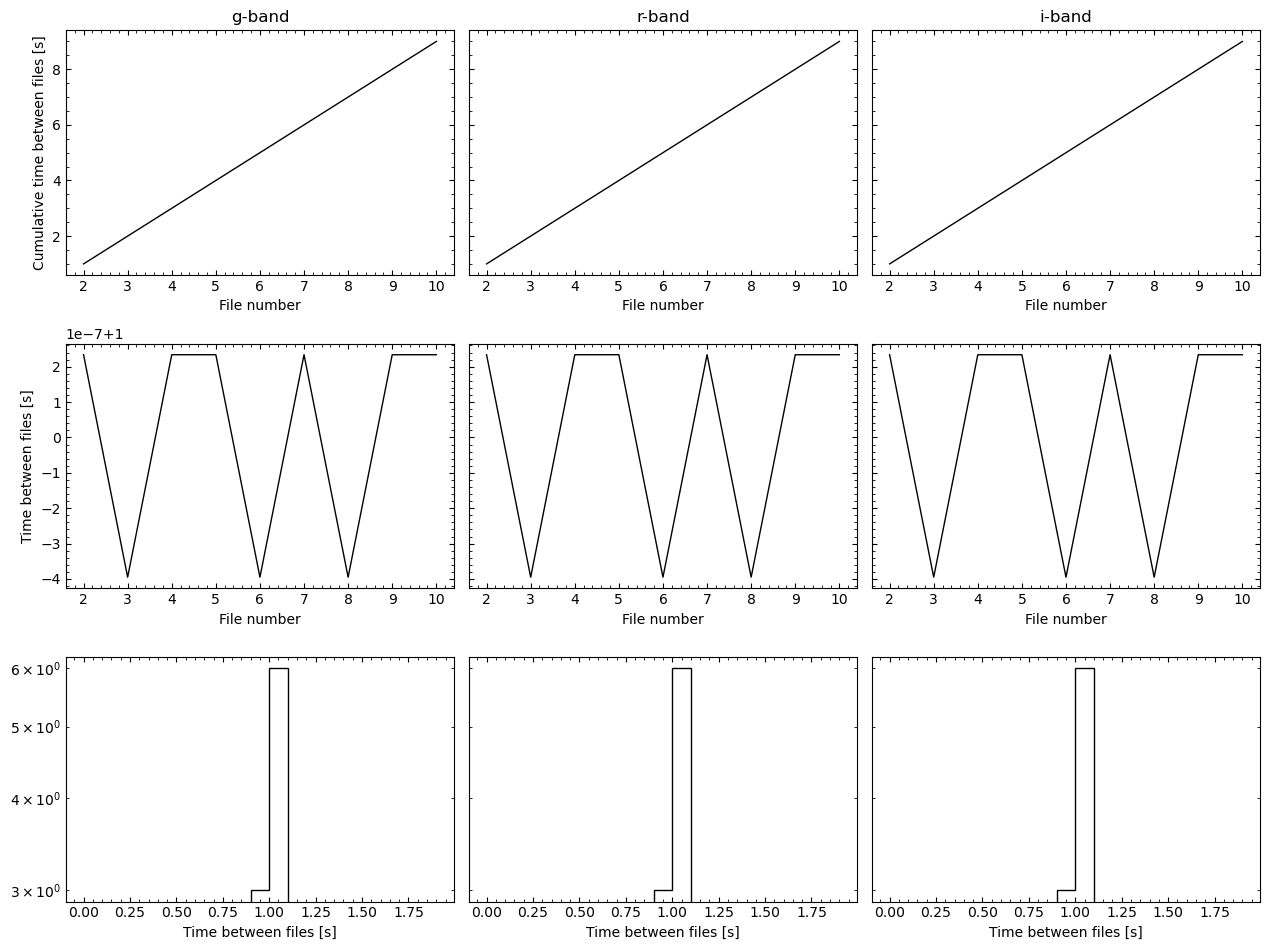

In [11]:
cat = opticam_new.Catalogue(
    data_directory='corrections_tutorial/data',  # path to the simulated data
    out_directory='corrections_tutorial/reduced',  # path to where output will be saved
    show_plots=True,
    flat_corrector=flat_corrector,  # pass the flat field corrector
    remove_cosmic_rays=False,
    )

[OPTICAM] Initialising catalogues ...


[OPTICAM] Aligning g-band images: 100%|██████████|[00:01<00:00]


[OPTICAM] Done.
[OPTICAM] 10 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning r-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 10 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning i-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 10 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


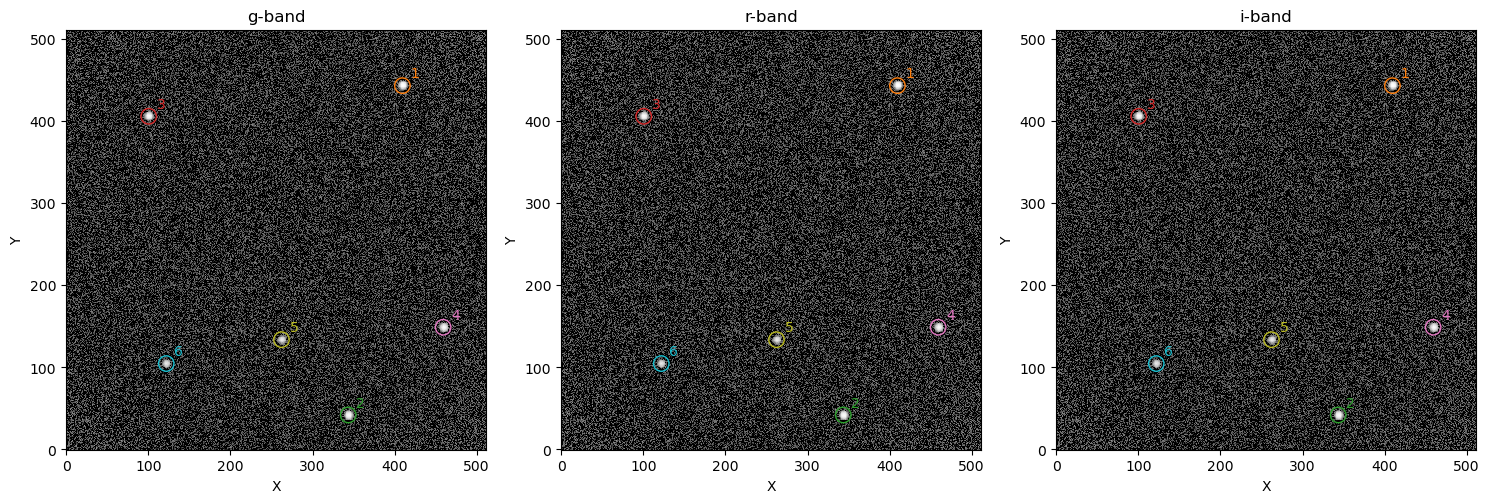

In [12]:
cat.initialise()

As we can see, the catalogue images also do not show an aperture shadow. 

### Creating Master Flats (Short Way)

We can create master flat-field images with fewer lines of code by letting `opticam_new` handle the master flat creation automatically:

[OPTICAM] 5 i-band flat-field images.
[OPTICAM] 5 g-band flat-field images.
[OPTICAM] 5 r-band flat-field images.
[OPTICAM] corrections_tutorial/reduced_auto not found, attempting to create ...
[OPTICAM] corrections_tutorial/reduced_auto created.


[OPTICAM] Scanning data directory: 100%|██████████|[00:00<00:00]

[OPTICAM] Binning: 4x4
[OPTICAM] Filters: g-band, r-band, i-band
[OPTICAM] 10 g-band images.
[OPTICAM] 10 r-band images.
[OPTICAM] 10 i-band images.


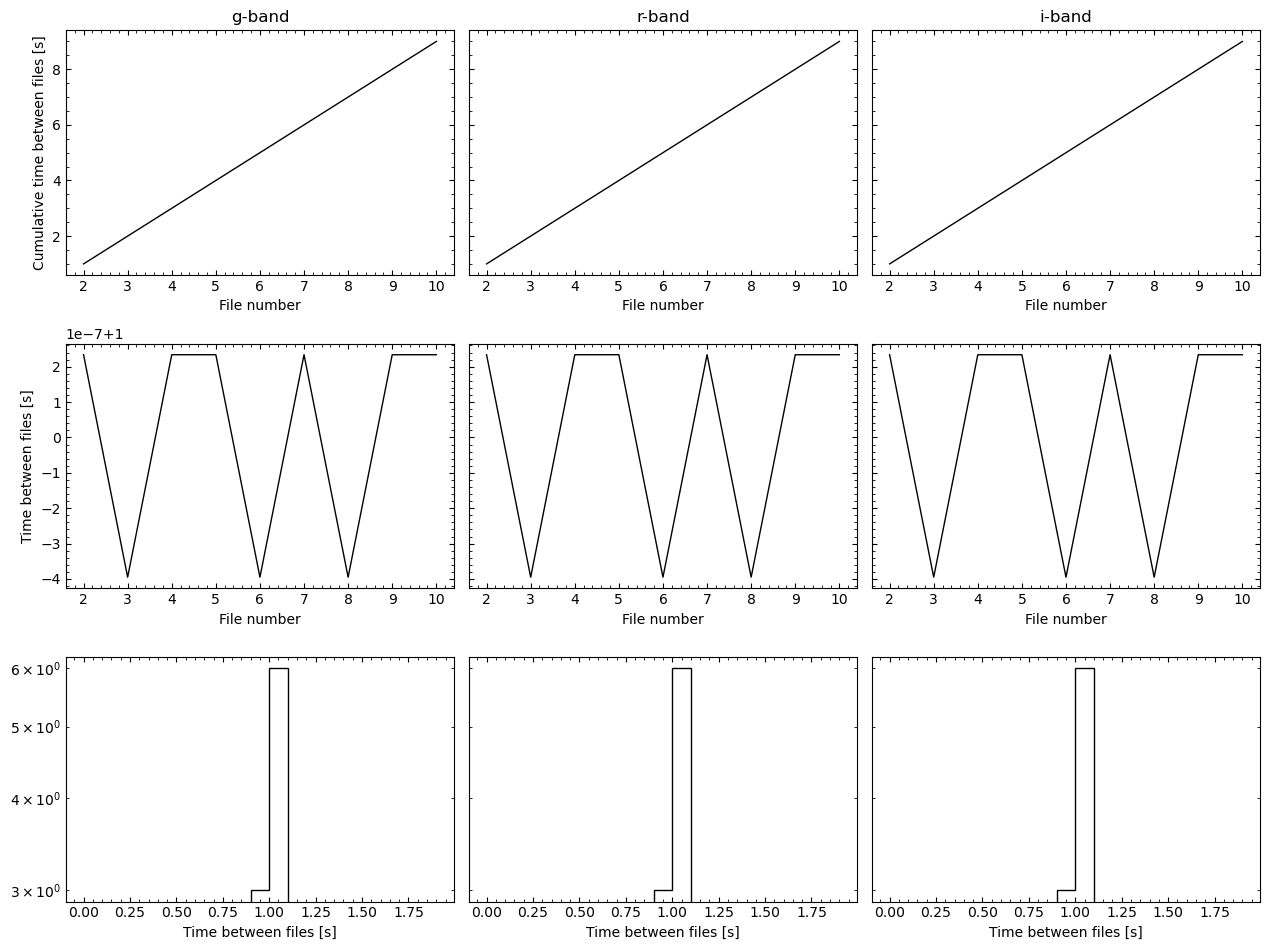

In [13]:
auto_flat_corrector = opticam_new.FlatFieldCorrector(
    out_dir='corrections_tutorial/correctors_auto',  # where the master flat field images will be stored
    flats_dir='corrections_tutorial/flats',  # where the flat field images are stored
    )

cat = opticam_new.Catalogue(
    data_directory='corrections_tutorial/data',  # path to the simulated data
    out_directory='corrections_tutorial/reduced_auto',  # path to where output will be saved
    show_plots=True,
    flat_corrector=auto_flat_corrector,  # pass the flat field corrector
    remove_cosmic_rays=False,
    )

Currently, the flat corrector has not been used, and so if we check for the master flats we will find that they don't yet exist:

In [14]:
os.path.isdir('corrections_tutorial/correctors_auto/master_flats')

False

However, if we initialise the catalogue we will see that the master flats will be created automatically so that they can be applied to the images:

[OPTICAM] Initialising catalogues ...
[OPTICAM] g-band master flat-field image not found. Attempting to create...
[OPTICAM] Master flat-field image created.


[OPTICAM] Aligning g-band images: 100%|██████████|[00:01<00:00]


[OPTICAM] Done.
[OPTICAM] 10 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning r-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 10 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning i-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 10 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


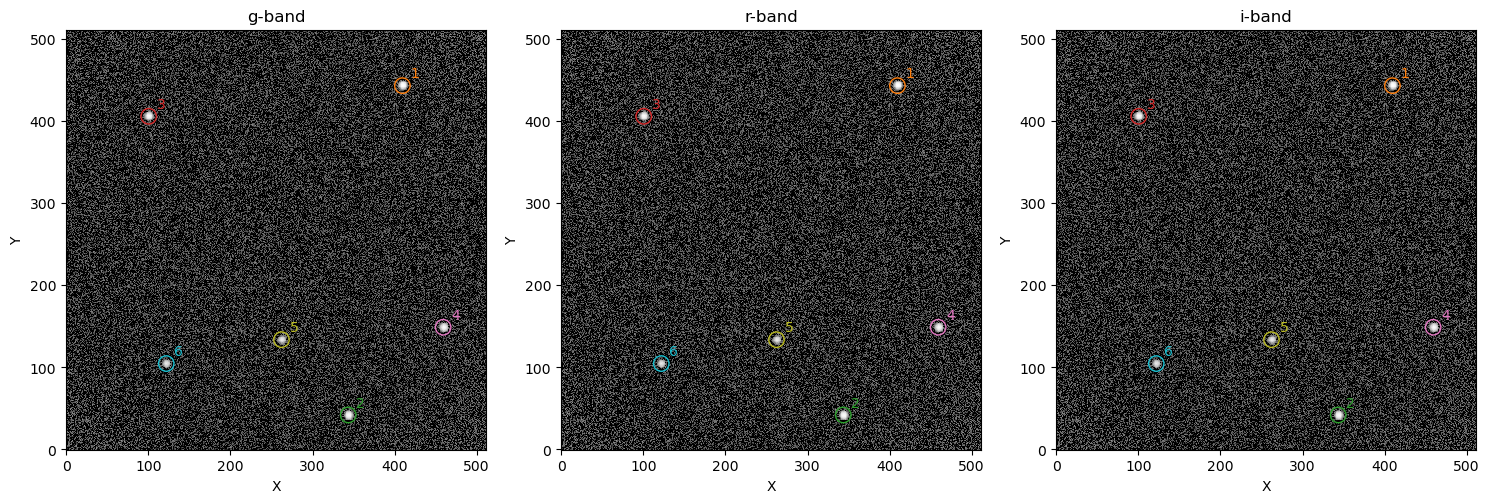

In [15]:
cat.initialise()

As we can see, the master flats were created and the corrections were applied. For completeness, let's also check if the master flats directory now exists:

In [16]:
os.path.isdir('corrections_tutorial/correctors_auto/master_flats')

True

With just a few lines of code, we have created master flats and used them to correct our observation images!

That concludes the corrections tutorial for `opticam_new`! Currently, image corrections are limited to flat-field corrections, but we plan to include more complete CCD corrections in future.